<a href="https://colab.research.google.com/github/HanSeoulOh/mathproblems/blob/master/stochasticGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Processes in Graphs
##### Han Du

The purposes of this notebook is to study stochastic processes and algorithms on graphs.

We will study random graphs $G = (N, p)$ where $N$ is fixed number of vertices and $p$ represents the probability of an edge being included.

We will represent graphs as an adjacency matrix $A$ of $G$.

$A_{i,j} = 1$ if there is an interaction between node i and node j.

$A_{i,i}$ represents the value stored by node i.


####Helper Code

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd


# graph initialization

n = 10
p = 0.5

def initializeGraph(n, p):
    upperDiagIndices = np.triu_indices(n, 1)
    A = np.zeros((n, n))
    return upperDiagIndices, A

def randomizeEdges(A, n, p):
    m = map((lambda x: x < p), np.random.rand(int((n-1) * n / 2)))
    edges = np.array([1 if e else 0 for e in m])
    A[upperDiagIndices] = edges
    return A


def randomAccumulate(A, n, p):
    randIdx = np.random.randint(low = 0, high = n)
    A[randIdx, randIdx] += 1
    return A


def drawGraph(A):
    nxA = nx.from_numpy_matrix(A)
    labelDict = dict(zip(nxA, np.diag(A).astype(int).tolist()))
    nx.draw(nxA, labels = labelDict)
    ax = plt.gca()
    ax.set_aspect('equal')


def oneStepPropagation(A):
    changed = []
    for i, row in enumerate(A):
        for j, column in enumerate(row):
            if i != j:
                if A[i, j] == 1 and i not in changed and j not in changed:
                    maxIJ = max(A[i, i], A[j, j])
                    if A[i, i] < maxIJ:
                        changed.append(i)
                    elif A[j, j] < maxIJ:
                        changed.append(j)
                    else:
                      pass
                    A[i, i] = maxIJ
                    A[j, j] = maxIJ
    return A
    # print(changed)


def checkAllEqual(A):
    return (np.diag(A) == A[0,0]).all()



### Generating Degree Sequences

The degree sequence of an undirected graph is the non-increasing sequence of its vertex degrees.
The degree sequence is a graph invariant so isomorphic graphs have the same degree sequence.
In some cases, non-isomorphic graphs have the same degree sequence.

In a $k$-connected graph of $N$ edges, we have a degree sequence $S = (k, ..., k)$ where $|S| = N$





## Constant Information Propagation in a Random Network from a Single Source

We start with studying the speed of information propagation in a graph where values of nodes are updated by the rule:

$A_{i,j} = 1 \implies \max{(A_{i,i},A_{j,j})} \rightarrow A_{i,i}, A_{j,j}$

After an adjacent node is updated, those nodes do not update adjacent nodes until the next time step or iteration of the propagation rule.

### Constant information

In this section we study how quickly constant information $C$ propagates in a constant sized graph $G = (N, p)$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


In [1]:
queue = []
iterations = 100000
for i in range(iterations):
    count = 0
    upperDiagIndices, A = initializeGraph(n, p)
    A = randomizeEdges(A, n, p)
    A = randomAccumulate(A, n, p)
    # print(A)
    while not checkAllEqual(A):
        A = randomizeEdges(A, n, p)
        A = oneStepPropagation(A)
        # print(A)
        count +=1
    queue.append(count)
    count = 0

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 3.30184 iterations until the entire network has updated in value.


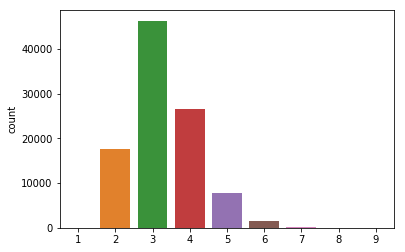

In [2]:
sns.countplot(list(map(int, queue)))

### Incrementing information

Here we introduce a new concept of incrementing information:

i.e. $C_t \geq C_{t-1} \; \forall t$

Where $t$ is time and $C_t$ is determined by an arbitrary monotonically increasing function $f(t)$

We measure the lag $L$ by:

$\displaystyle L(G_t) = \sum_{i}^{N}{C_t - A_{i,i}}$

For our simulation, we select $f(t) = t$

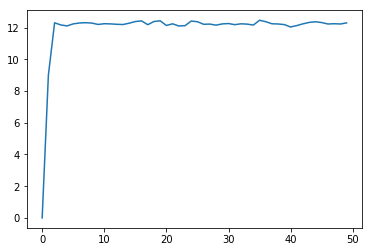

In [4]:
def randomAssign(A, n, p, t):
    randIdx = np.random.randint(low = 0, high = n)
    A[randIdx, randIdx] = t
    return A

def lag(A, t):
    return sum(np.ones(np.diag(A).shape) * t - np.diag(A))


def f(timestep):
    return timestep

maxTime = 50
iterations = 1000
n = 10
p = 1
lags = np.zeros((iterations, maxTime))
for iter in range(iterations):
    count = 0
    upperDiagIndices, A = initializeGraph(n, p)
    A = randomizeEdges(A, n, p)
    # print(A)
    while count < maxTime:
        A = oneStepPropagation(A)
        A = randomizeEdges(A, n, p)
        A = randomAssign(A, n, p, count)
        lags[iter, count] = lag(A, count)
        count += 1
    count = 0


sns.lineplot(data=pd.DataFrame(lags).mean())

## Constant Information Propagation in K-Connected Graphs from a Single Source

Here we will study the speed of the propagation of a constant information packet in a $k$-connected random graph, using the same information update rule as previous sections.

In this section we study how quickly constant information $C$ propagates in a k connected graph $G$ constructed from the degree sequence $(k, ..., k)$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


In [8]:
sequence = [3 for i in range(10)]
queue = []
iterations = 10000
for i in range(iterations):
    count = 0
    A = nx.to_numpy_matrix(nx.random_degree_sequence_graph(sequence))
    # print(A)
    A = randomAccumulate(A, n, p)
    while not checkAllEqual(A) and count < 100:
        A = oneStepPropagation(A)
        D = np.diag(A)
        # print(A)
        count +=1
        A = nx.to_numpy_matrix(nx.random_degree_sequence_graph(sequence))
        A[np.diag_indices(n)] = np.asmatrix(D)
    queue.append(count)
    count = 0

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 10.2736 iterations until the entire network has updated in value.


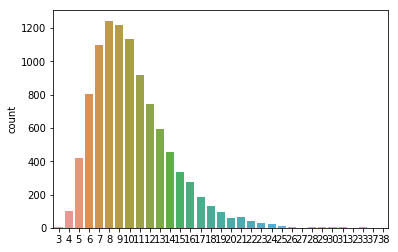

In [9]:
sns.countplot(list(map(int, queue)))

In [11]:
print("standard deviation: " + str(np.std(queue)))

standard deviation: 3.7847778058956116


## Constant Information Propagation in $\leq$ K-Connected Graphs from a Single Source

In this section we study how quickly constant information $C$ propagates in a k connected graph $G$ constructed from the degree sequence $(d_1, ..., d_n)$ where $d_i \leq k$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


In [0]:
k = 3
queue = []
iterations = 10000
dsList = []

graphList = []
for i in range(iterations):
    sequence = np.random.poisson(k, 10) + 1
    sequence = np.flip(np.sort(sequence))
    dsList.append(sequence)



In [0]:
validDSList = []
for sequence in dsList:
    if nx.is_graphical(np.flip(np.sort(sequence))):
      validDSList.append(sequence)

In [0]:
for sequence in validDSList:
    try:
      G = nx.random_degree_sequence_graph(sequence, None, 1)
    except:
      pass
    if nx.is_connected(G):
      A = nx.to_numpy_matrix(G)
      graphList.append(A)

In [67]:
len(graphList)

4749

In [72]:
import random
for graph in graphList:
    count = 0
    A = np.zeros((n,n)) + graph
    # print(A)
    A = randomAccumulate(A, n, p)
    while not checkAllEqual(A) and count < 100:
        A = oneStepPropagation(A)
        D = np.diag(A)
        # print(A)
        count +=1
        A = np.zeros((n,n)) + random.choice(graphList)
        A[np.diag_indices(n)] = np.asmatrix(D)
    queue.append(count)
    count = 0

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 2.4014 iterations until the entire network has updated in value.


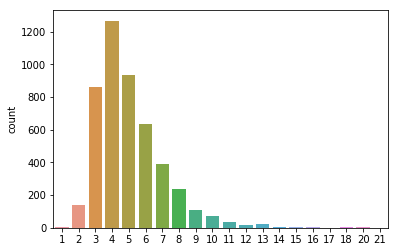

In [73]:
sns.countplot(list(map(int, queue)))